In [43]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers


In [44]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# display(data)

In [45]:
def create_X_y_rolling(df, window_size):
    X, y, first_values = [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value  
        X.append(normalized_window.values)
        y_target = df.iloc[i+window_size] / first_value  
        y.append(y_target.values)
        first_values.append(first_value.values) 
    X = np.array(X)
    y = np.array(y)
    first_values = np.array(first_values)
    return X, y, first_values

window_size = 30
X, y, first_values = create_X_y_rolling(data, window_size)


In [46]:
dataset_size = len(X)
print(dataset_size)


train_size = int(dataset_size * 0.8)
test_size =int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size


X_train, X_val, X_test = X[:train_size], X[train_size: train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test= y[:train_size], y[train_size: train_size + val_size], y[train_size + val_size:]


first_values_test = first_values[train_size + val_size:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


3378


((2702, 30, 33),
 (2702, 33),
 (339, 30, 33),
 (339, 33),
 (337, 30, 33),
 (337, 33))

In [47]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  
    LSTM(64, return_sequences=False),  
    Dense(y_train.shape[1])  
])


model.compile(loss=MeanSquaredError(), 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

cp = ModelCheckpoint(filepath='model_regression/best_LSTM.keras', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp, es],
)
# model.summary()



c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 0.3259 - mean_squared_error: 0.3258 - val_loss: 0.0069 - val_mean_squared_error: 0.0066
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0051 - val_mean_squared_error: 0.0050
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0046 - 

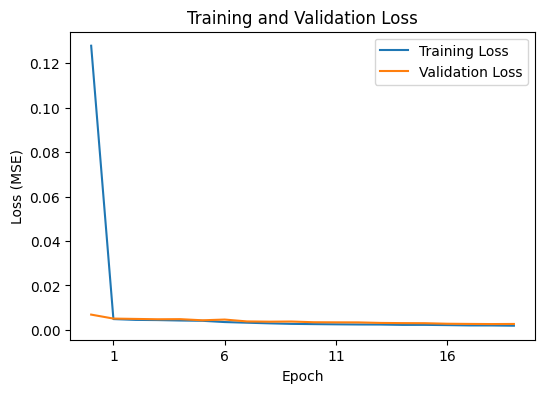

In [48]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 20, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,30.969717,9.714998,65.361862,21.586278,14.808245,108.822887,48.691308,20.706743,33.704307,26.224573,...,22.697279,441.231161,82.744159,69.909580,124.002348,103.967385,60.643489,74.896419,67.280912,6.536036
2023-12-08,30.930748,9.859318,65.556546,21.605330,15.192162,109.692874,48.658490,20.668885,33.423966,26.244556,...,23.180661,441.427610,82.890929,69.443194,120.778022,103.874062,60.503436,73.999778,67.890320,6.611396
2023-12-11,30.741782,9.814274,65.165122,21.637092,14.404003,110.188447,48.840428,20.783541,33.609426,26.352625,...,23.089250,444.473740,82.382215,67.891584,120.309600,103.433660,60.870511,74.142969,67.882823,6.544297
2023-12-12,31.008715,9.697792,65.948974,21.651911,14.262338,110.983704,48.627959,20.695012,33.503167,26.436490,...,22.709106,446.482268,81.996566,67.168947,120.834934,103.898571,60.883901,75.272551,68.179496,6.513334
2023-12-13,31.141581,9.709196,65.877488,21.494169,14.116756,110.316009,49.105113,20.974447,33.685711,26.488802,...,22.624854,449.362700,83.839344,66.353736,119.432390,104.612214,60.749202,75.315640,68.801012,6.522415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,41.474933,10.997395,116.615779,19.108666,13.787058,112.452535,57.267034,25.066165,42.194134,36.776011,...,28.627965,621.654243,86.892969,72.667549,128.929085,151.228198,70.980771,92.773793,74.211451,7.353964
2025-03-25,41.222875,11.013077,115.608047,18.959960,13.927584,113.671697,57.219392,25.017352,42.252666,37.249188,...,28.515535,621.728524,86.570963,73.306762,129.579517,151.276092,71.496887,93.169522,74.253776,7.347836
2025-03-26,41.138077,11.048125,114.746499,19.217330,13.792902,112.672990,57.127650,25.322083,42.264222,37.576016,...,28.836216,619.834487,84.919599,73.128798,127.336183,150.515896,71.923182,92.113565,73.891840,7.349545


<Axes: xlabel='Date'>

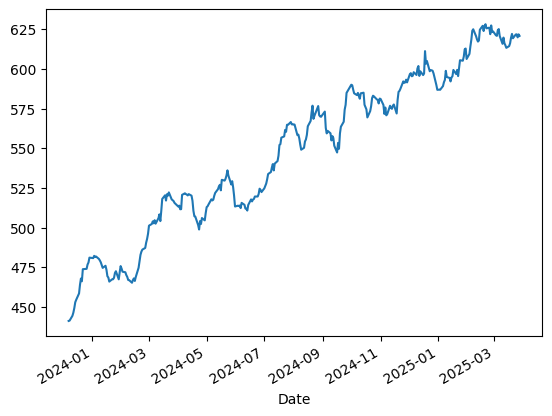

In [49]:
model = load_model('model_regression/best.keras')
index_series = data.index[-len(y_test):]  # Use the last indices for the test set

Y_pred = model.predict(X_test)
Y_pred_denorm = Y_pred * first_values_test  

Predict_result_df = pd.DataFrame(Y_pred_denorm, index=index_series, columns=data.columns)

display(Predict_result_df)

Predict_result_df["SPY"].plot()


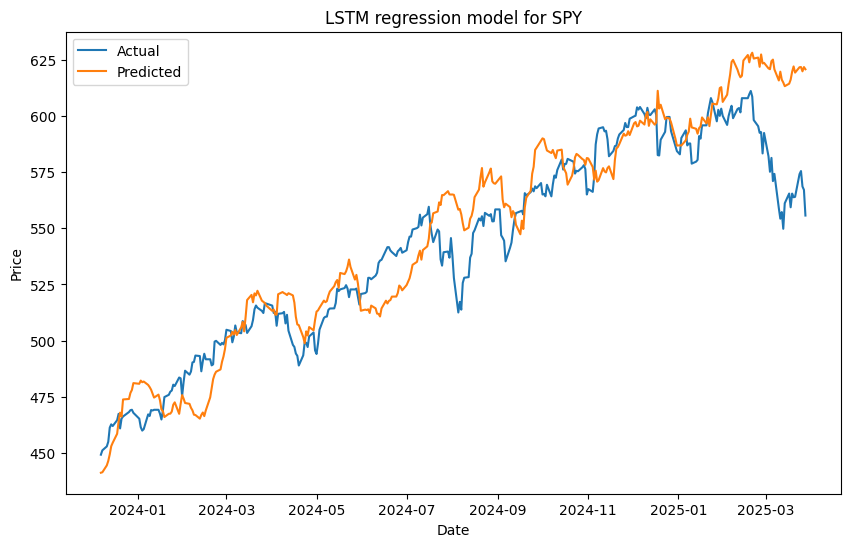

In [50]:
y_test_denorm = y_test * first_values_test
y_actual = pd.DataFrame(y_test_denorm, index=index_series, columns=data.columns)
ticker_name = 'SPY'

plt.figure(figsize=(10,6))
plt.plot(y_actual[ticker_name], label='Actual')
plt.plot(Predict_result_df[ticker_name], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM regression model for {ticker_name}')
plt.legend()
plt.show()

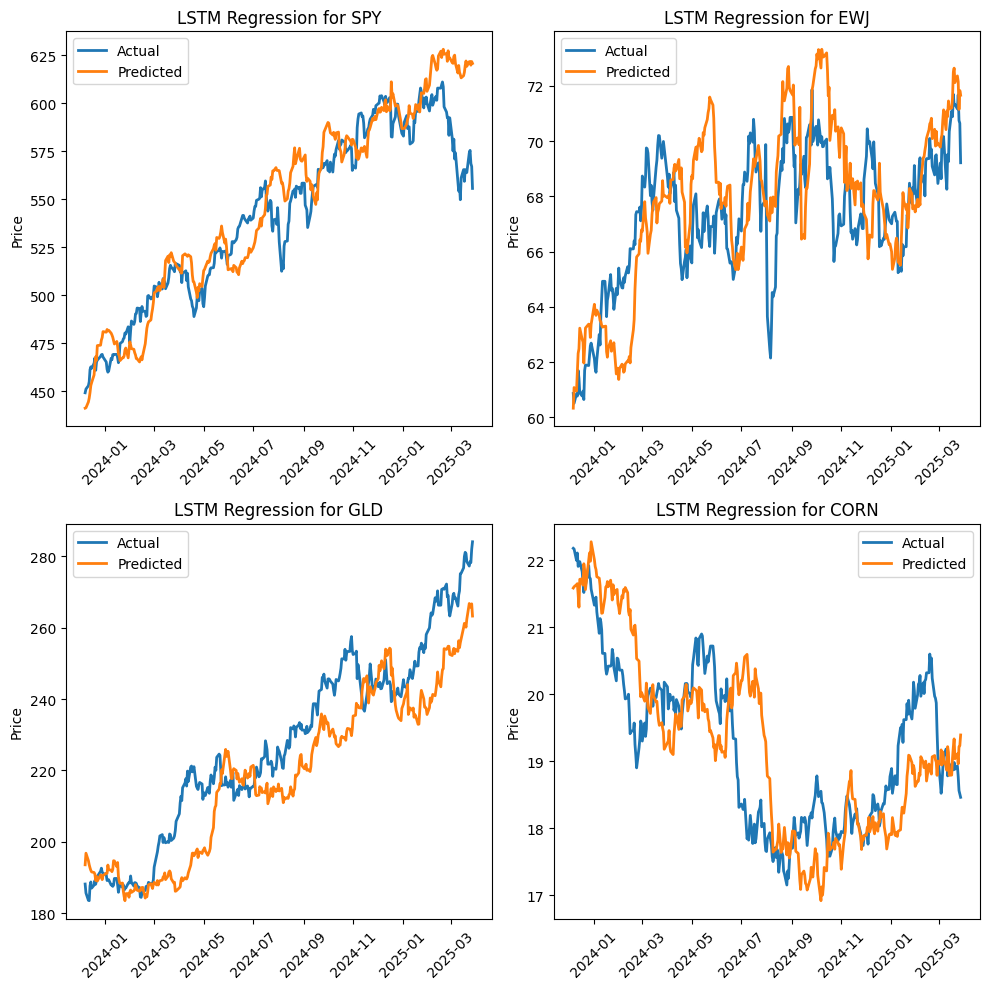

In [51]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  

num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten() 


for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Predict_result_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [52]:
label = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
label_test = label.iloc[-len(y_test):]
label_test.set_index('Date', inplace=True)
display(label_test)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,1,0,1,1,1,1,1,0,1,...,0,1,0,1,0,0,1,1,1,0
2023-12-08,1,0,1,0,1,0,0,1,1,1,...,0,1,0,1,1,1,1,0,0,0
2023-12-11,1,1,0,0,1,0,1,0,1,1,...,0,1,0,1,1,1,1,1,1,1
2023-12-12,0,0,1,1,0,0,0,1,0,1,...,0,1,1,0,0,1,1,0,1,0
2023-12-13,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [53]:
Predict_result_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,30.969717,9.714998,65.361862,21.586278,14.808245,108.822887,48.691308,20.706743,33.704307,26.224573,...,22.697279,441.231161,82.744159,69.909580,124.002348,103.967385,60.643489,74.896419,67.280912,6.536036
2023-12-08,30.930748,9.859318,65.556546,21.605330,15.192162,109.692874,48.658490,20.668885,33.423966,26.244556,...,23.180661,441.427610,82.890929,69.443194,120.778022,103.874062,60.503436,73.999778,67.890320,6.611396
2023-12-11,30.741782,9.814274,65.165122,21.637092,14.404003,110.188447,48.840428,20.783541,33.609426,26.352625,...,23.089250,444.473740,82.382215,67.891584,120.309600,103.433660,60.870511,74.142969,67.882823,6.544297
2023-12-12,31.008715,9.697792,65.948974,21.651911,14.262338,110.983704,48.627959,20.695012,33.503167,26.436490,...,22.709106,446.482268,81.996566,67.168947,120.834934,103.898571,60.883901,75.272551,68.179496,6.513334
2023-12-13,31.141581,9.709196,65.877488,21.494169,14.116756,110.316009,49.105113,20.974447,33.685711,26.488802,...,22.624854,449.362700,83.839344,66.353736,119.432390,104.612214,60.749202,75.315640,68.801012,6.522415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,41.474933,10.997395,116.615779,19.108666,13.787058,112.452535,57.267034,25.066165,42.194134,36.776011,...,28.627965,621.654243,86.892969,72.667549,128.929085,151.228198,70.980771,92.773793,74.211451,7.353964
2025-03-25,41.222875,11.013077,115.608047,18.959960,13.927584,113.671697,57.219392,25.017352,42.252666,37.249188,...,28.515535,621.728524,86.570963,73.306762,129.579517,151.276092,71.496887,93.169522,74.253776,7.347836
2025-03-26,41.138077,11.048125,114.746499,19.217330,13.792902,112.672990,57.127650,25.322083,42.264222,37.576016,...,28.836216,619.834487,84.919599,73.128798,127.336183,150.515896,71.923182,92.113565,73.891840,7.349545


In [54]:
y_test_shift = data[train_size + val_size + window_size - 1: -1]
y_test_shift_index = data.index[train_size + val_size + window_size-1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_denorm > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
display(predicted_directions_df)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,0,1,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0
2023-12-08,0,1,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,1,0,1,1
2023-12-11,0,1,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,1,0,1,1
2023-12-12,0,1,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,1,0,1,1
2023-12-13,0,1,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,0,1,1,1,1,0,...,0,1,0,0,1,1,0,1,0,0
2025-03-25,1,1,1,1,0,1,1,1,1,0,...,0,1,0,0,1,1,0,1,0,0
2025-03-26,1,1,1,1,0,1,1,1,1,0,...,0,1,0,0,0,1,0,1,0,0


In [55]:
actual_flat = label_test.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

matches = np.sum(actual_flat == predicted_flat)
percentage = (matches / len(actual_flat)) * 100
print(f"Match Percentage: {percentage:.2f}%")

accuracy = accuracy_score(actual_flat, predicted_flat)
print(f'Accuracy of the model: {accuracy:.4f}')

Match Percentage: 50.89%
Accuracy of the model: 0.5089


In [56]:
yesterday_prices = data.iloc[-2]  
today_prices_actual = data.iloc[-1] 
Y_pred_mean = Y_pred_denorm.mean(axis=0)
today_prices_predicted = pd.Series(Y_pred_mean.flatten(), index=data.columns)
comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_pred': today_prices_predicted,
})
tickers_names = data.columns
correct_list = []
for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]
    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)
    if sign_actual == sign_pred:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list
count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
display(comparison_df)
# save_df = pd.DataFrame()
# save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
# save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
# save_df['Today pred target'] = comparison_df['Today_pred'].apply(lambda x: round(x, 2))
# save_df['Correct'] = comparison_df['Correct']
# display(save_df)
# save_df.to_csv('rnn_regression.csv', index=True)


Count of correct predictions: 22
accuracy: 0.6666666666666666


,Yesterday_actual,Today_actual,Today_pred,Correct
AIEQ,37.658001,36.845001,36.743578,1
ASHR.L,10.460000,10.340000,9.638082,1
BCHN.L,97.080002,92.714996,94.933446,1
CORN,18.510000,18.459999,19.256943,0
DBO,14.130000,13.970000,14.241917,0
EDEN,105.330002,105.169998,121.051867,0
EMXC,56.110001,55.180000,56.140015,0
EWA,23.750000,23.469999,24.184414,0
EWC,41.250000,40.570000,38.878494,1
EWG,37.590000,37.389999,31.532170,1
